In [1]:
"""
Name: example.ipynb
Authors: Stephan Meighen-Berger
Example for the package
"""

'\nName: example.ipynb\nAuthors: Stephan Meighen-Berger\nExample for the package\n'

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config

In [6]:
# Some example settings
# Scenario
config['scenario']['population size'] = 100
config['scenario']['duration'] = 720 * 5
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['rate'] = 0.1
config['scenario']['injection']['y range'] = [7.5, 12.5]
config['scenario']['light prop']: {
            "switch": True,
            "x_pos": 5.,
            "y_pos": 10.,
        }
# Organisms
config['organisms']['emission fraction'] = 0.1
config['organisms']['alpha'] = 1.
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 40.,
    'y_length': 20.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 40.,
    'y_length': 5.,
    "offset": np.array([0., 7.5]),
}
config['geometry']["exclusion"]: {
    "function": "sphere",
    "radius": 0.3,
    "x_pos": 5.,
    "y_pos": 10.,
}
# Water
config['water']['model']['name'] = 'custom'
config['water']['model']['time step'] = 60

In [7]:
# Creating a fourth_day object
fd = Fourth_Day()

In [8]:
# Launching solver
fd.sim()

In [9]:
fd.statistics[-1]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,regeneration,is_emitting,emission_duration,encounter photons,shear photons,photons
0,Paraphyllina ransoni Russell,40.026023,8.055016,0.0,0.000000,0.001357,1.0,False,10.877831,0.1,0.001,False,-588.0,0.0,0.0,0.0
1,Aeginura grimaldii Maas,35.335052,17.992566,0.0,1.275677,0.001191,1.0,False,1.135903,0.1,0.001,False,0.0,0.0,0.0,0.0
2,Praya dubia (Quoy and Gaimard),11.517495,13.313054,0.0,1.003611,0.001422,1.0,False,7.875777,0.1,0.001,False,0.0,0.0,0.0,0.0
3,Nectopyramis natans (Bigelow),20.350858,14.689363,0.0,0.148222,0.001231,1.0,False,4.946962,0.1,0.001,False,0.0,0.0,0.0,0.0
4,Periphyllopsis braueri Vanhoeffen,5.867679,0.858577,0.0,4.555514,0.001364,1.0,False,7.745598,0.1,0.001,False,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Halicreidae unidentified speciese,2.879914,12.353511,0.0,0.000000,0.001598,1.0,True,3.877811,0.1,0.001,False,-48.0,0.0,0.0,0.0
396,Praya dubia (Quoy and Gaimard),2.157840,9.216435,0.0,0.000000,0.000959,1.0,True,5.839335,0.1,0.001,False,-36.0,0.0,0.0,0.0
397,Vogtia serrata (Moser),1.439661,8.211490,0.0,0.000000,0.000778,1.0,True,2.069506,0.1,0.001,False,-24.0,0.0,0.0,0.0
398,Chuniphyes multidentata Lens and van Riemsdijk,0.719926,9.834054,0.0,0.000000,0.001041,1.0,True,27.152290,0.1,0.001,False,-12.0,0.0,0.0,0.0


In [10]:
# Plotting standards
std_size = 10.
fontsize = 20.
lw=3.
h_length=1.5

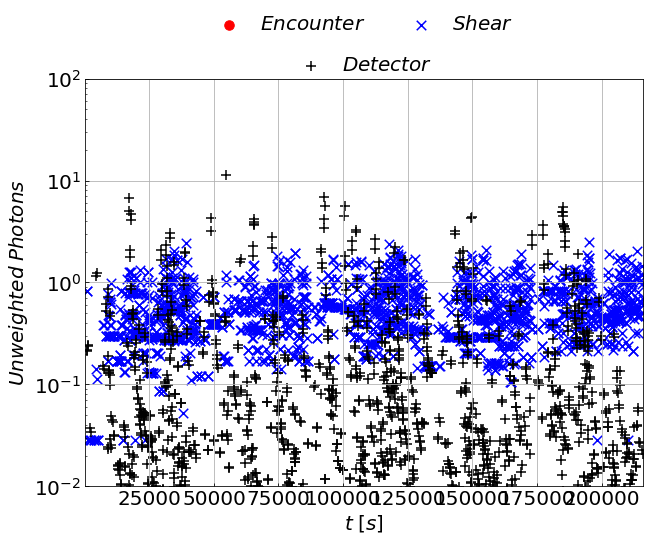

In [11]:
# Energy distributions
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
data_enc = np.array([np.sum(fd.statistics[i].loc[:, 'encounter photons'].values)
                     for i in range(len(fd.t))])
data_shear = np.array([np.sum(fd.statistics[i].loc[:, 'shear photons'].values)
                       for i in range(len(fd.t))])
data = np.array([np.sum(fd.statistics[i].loc[:, 'photons'].values)
                     for i in range(len(fd.t))])
ax1.scatter(fd.t,
            data_enc,
            s=lw*30, color='r', label=r'$Encounter$', marker="o")
ax1.scatter(fd.t,
            data_shear,
            s=lw*30, color='b', label=r'$Shear$', marker="x")
ax1.scatter(fd.t,
            fd.light_yields,
            s=lw*30, color='k', label=r'$Detector$', marker="+")
ax1.set_xlim(1e0, max(fd.t))
ax1.set_ylim(1e-2, 1e2)
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$t\;[s]$', fontsize=fontsize)
ax1.set_ylabel(r'$Unweighted\;Photons$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h[:2],l[:2], loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
lgd2 = ax1.legend(h[2:],l[2:], loc=9, bbox_to_anchor=(0.5, +1.1),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.add_artist(lgd1)
plt.show()

In [12]:
figure.savefig(PICS + "MC_Example.png",
               bbox_inches='tight')